<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20240220_p2_Continuous_Control_1_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<TOP>**  
* OpenAI Spnning up: [Deep Deterministic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)  
* github [@ShangtongZhang/DeepRL](https://github.com/ShangtongZhang/DeepRL/tree/master/deep_rl) -> **`./python/deeprl`** (and `./python/deeprl_files`)  
* github [@openai/baselines](https://github.com/openai/baselines) -> `./python/baselines`     
* set up local env ([gist](https://gist.github.com/Nov05/1d49183a91456a63e13782e5f49436be))  
* `mujoco-py` installation in colab [example notebook](https://colab.research.google.com/drive/1KGMZdRq6AemfcNscKjgpRzXqfhUtCf-V)  

---
👉 whenever you have changed the code files, Ctrl+M. to restart the session, and run [this cell](#scrollTo=C2zSdLsICHby).

---

In [ ]:
## VERSION="22.04.3 LTS (Jammy Jellyfish)"
!lsb_release -a
import platform; print(platform.system(), platform.release())
import torch; print(f"torch {torch.__version__}") ## torch 2.1.0+cu121
import tensorflow; print("tensorflow", tensorflow.__version__) ## tensorflow 2.15.0
import gym; print("gym", gym.__version__) ## gym 0.25.2
import numpy as np; print("numpy", np.__version__)

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Linux 6.1.58+
torch 2.1.0+cu121
tensorflow 2.15.0
gym 0.25.2
numpy 1.25.2


# **Set up environment**  

In [1]:
%%capture
## get the reacher (1 agent) build. you don't need to install ml-agents.
!wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux.zip
!unzip Reacher_Linux.zip
!mv Reacher_Linux Reacher_Linux_1
!rm Reacher_Linux.zip

## get the reacher (20 agents) build. you don't need to install ml-agents.
!wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip -O Reacher_Linux_20.zip
!unzip Reacher_Linux_20.zip
!mv Reacher_Linux Reacher_Linux_20
!rm Reacher_Linux_20.zip

In [2]:
%%file /root/.ipython/profile_default/startup/startup.py
## auto setup of the env variables whenever the session restarts
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
# os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco200/bin'
# os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libGLEW.so' <- not in use
## !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/.mujoco/mujoco210/bin <- this won't work in colab
## %ENV LD_LIBRARY_PATH /root/.mujoco/mujoco210/bin:${LD_LIBRARY_PATH} <- cell magic command. however, I don't know how to concatenate the old value

Writing /root/.ipython/profile_default/startup/startup.py


In [3]:
!pip install numpy==1.23.5

## load/reload all the python code
%cd /content
!rm -rf /content/python
!git clone https://github.com/Nov05/udacity-deep-reinforcement-learning.git
!mv udacity-deep-reinforcement-learning/python python
!rm -r udacity-deep-reinforcement-learning
!rm -rf /content/python/baselines
!rm -rf /content/python/mujoco-py

## install mujoco-py (mujoco-py causes compiling errors, use free-mujoco-py instead)
## for mujoco-py installation
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common
!apt-get install -y patchelf
%cd /content/python
!pip install free-mujoco-py
# #### update cython version
# # !pip install -U cython
# ## Requirement already satisfied: cython in /usr/local/lib/python3.10/dist-packages (3.0.8)
# !pip install cython==3.0.0a10
# # !pip install mujoco-py
# ## Successfully installed fasteners-0.19 glfw-2.7.0 mujoco-py-2.1.2.14
# # !pip install mujoco-py==2.0.2.8
# #### install from github repo
# %cd /content/python
# !git clone https://github.com/openai/mujoco-py
# %cd mujoco-py
# !pip install -r --no-cache-dir requirements.txt
# !pip install -r --no-cache-dir requirements.dev.txt
# !pip install -e . --no-cache

## install mujoco
%cd /content
!mkdir /root/.mujoco
!gdown https://www.roboti.us/file/mjkey.txt
!mv mjkey.txt /root/.mujoco/
!gdown https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz
!tar -xvf mujoco210-linux-x86_64.tar.gz
!mv mujoco210 /root/.mujoco/
# !gdown https://www.roboti.us/download/mujoco200_linux.zip
# !unzip mujoco200_linux.zip
# !mv mujoco200_linux /root/.mujoco/mujoco200

## install openai baselines for tensorflow==2.15.0
%cd /content/python
# !git clone https://github.com/openai/baselines.git ##  for tensorflow==1.X
!git clone --branch tf2 https://github.com/openai/baselines.git  ## for tensorflow==2.15.0
%cd baselines
!pip install -e . --no-cache

## baselines will install gym==0.13.1
## update gym version or there will be errors
!pip install gym==0.14.0
!pip install gym[accept-rom-license,atari]
## Successfully installed atari-py-0.2.9
%cd /content/
!gdown https://www.atarimania.com/roms/Atari-2600-VCS-ROM-Collection.zip
!unzip Atari-2600-VCS-ROM-Collection.zip
%cd /content/python/
!python -m atari_py.import_roms /content/ROMS

## after the above steps, Ctrl+M. to restart session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.


Streaming output truncated to the last 5000 lines.
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Jawbreaker (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Journey Escape (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Joust (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Jr. Pac-Man (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Jungle Hunt (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Kaboom! (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Kangaroo (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Karate (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Keystone Kapers (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Killer Satellites (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/King Kong (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Klax (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Knight on the Town (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/H-R/Kung-Fu Master (PAL).bin  
  inflating: HC 

## **run this cell after session restart**    

In [ ]:
######################################################################
## if session has been restarted (Ctrl+M.), run from here (Ctrl+F10)
######################################################################
%cd /content/python
import warnings; warnings.filterwarnings("ignore")
import sys; sys.path.insert(1, "/content/python"); print(sys.path)
## if don't add the path, you will get the following errors.
# !python -m deeprl.component.env
## /usr/bin/python3: No module named deeprl.component.env
# !python /content/python/deeprl/component/envs.py
# %run deeprl/component/envs.py
## from ..utils import *
## ImportError: attempted relative import with no known parent package
import os; print(os.environ['LD_LIBRARY_PATH'])

/content/python
['/content', '/content/python', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/content/python/baselines', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
/usr/lib64-nvidia:/root/.mujoco/mujoco210/bin


## **run a Gym game + deeprl example**     

In [ ]:
%%time
from deeprl import *
if __name__ == '__main__':
    task = Task('Hopper-v2', num_envs=10, single_process=True)
    state = task.reset()
    for _ in range(100):
        actions = [np.random.rand(task.action_space.shape[0])] * len(task.envs_wrapper.envs)
        _, _, dones, _ = task.step(actions)
        if np.sum(dones): ## not all falses
            print(dones)
    task.close()
## range(100) ~ Wall time: 350 ms

Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

[False  True False False False False  True  True  True False]
[ True False  True  True  True  True False False False False]
[False False False False False False False False False  True]
[False False False False False  True  True  True  True False]
[ True  True False  True  True False False False False False]
[False False  True False False False False False False False]
[False False False False False False False False False  True]
[False False False  True False False False False False False]
[ True  True False False False  True  True  True  True False]
[False False  True False  True False False False False False]
[False False False False False False False False False  True]
CPU times: user 16.1 s, sys: 1.28 s, total: 17.4 s
Wall time: 1min 32s


## **run a Gym game + deeprl example, multiprocessing**  

In [ ]:
%%time
from deeprl import *
if __name__ == '__main__':
    task = Task('Hopper-v2', num_envs=10, single_process=False) ## multiprocessing
    state = task.reset()
    for _ in range(100):
        actions = [np.random.rand(task.action_space.shape[0])] * task.envs_wrapper.num_envs
        _, _, dones, _ = task.step(actions)
        if np.sum(dones):
            print(dones)
    task.close()
## range(100) ~ Wall time: 1min 37s

[False  True  True False False  True  True False  True  True]
[ True False False  True  True False False  True False False]
[False False  True False False False False False False  True]
[ True  True False  True False  True False False  True False]
[False False False False  True False  True  True False False]
[False False  True False False False False False False False]
[False False False  True False False False False  True False]
[ True  True False False False  True False  True False  True]
[False False False False  True False False False False False]
[False False False False False False  True False False False]
CPU times: user 663 ms, sys: 91.7 ms, total: 755 ms
Wall time: 1min 37s


## **run a deeprl example**    

In [ ]:
## choose GPU runtime for this cell
import subprocess
try:
    ## this command not being found can raise quite a few different errors depending on the configuration
    subprocess.check_output('nvidia-smi')
except Exception:
    raise RuntimeError('Go to the Runtime menu and select Choose runtime type.')

from deeprl import *
!python -m deeprl_files.examples
## log info similar to the following lines indicates the example code has been executed successfully.
## 2024-03-02 17:37:21,870 - root - INFO: steps 0, 524288000.00 steps/s
## 2024-03-02 17:37:22,551 - root - INFO: steps 0, episodic_return_test -11.66(1.04)

2024-03-02 17:36:07.538861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 17:36:07.538930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 17:36:07.540235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 17:36:08.578890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx
2024-03-02 17:36:18,338 - root - INFO: running build_ext
2024-03-02 17:36:1

## **run a Unity MLAgent + deeprl example**  

In [ ]:
%%time
## copy code from /content/python/deeprl/component/envs.py
## run single unity env with deeprl
import pandas as pd
pd.set_option('display.width', 180)
## local imports
from unityagents import UnityEnvironment
from deeprl import *
if __name__ == '__main__':
    # file_name = '/content/Reacher_Linux_1/Reacher.x86_64'
    file_name = '/content/Reacher_Linux_20/Reacher.x86_64'
    env = UnityEnvironment(file_name=file_name, no_graphics=True) ## CAUTION: no graphics in colab
    num_envs, env_id = 1, 0
    task = Task('Reacher-v2', num_envs=num_envs,
                envs=[env], is_mlagents=True, single_process=True)
    scores = np.zeros(task.envs_wrapper.num_agents)
    for i in range(10000):
        actions = [np.random.randn(task.envs_wrapper.num_agents, task.action_space.shape[0])] * task.num_envs
        _, rewards, dones, infos = task.step(actions)
        scores += rewards[env_id]
        if np.any(rewards[env_id]):
            print(pd.DataFrame([rewards[env_id], scores], index=['rewards','scores']))
        if np.any(dones[env_id]): ## if any agent finishes an episode
            print("An agent finished an episode!")
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    task.close()
    ## once the unity env is closed, you need to Ctrl+M. to restart the session to run it again.

          0    1    2    3    4    5    6    7    8    9    10   11   12   13    14   15   16   17   18   19
rewards  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.01  0.0  0.0  0.0  0.0  0.0
scores   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.01  0.0  0.0  0.0  0.0  0.0
          0    1    2    3    4    5    6    7    8    9    10   11   12   13    14   15   16   17   18   19
rewards  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.0  0.0  0.0  0.0  0.0
scores   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.05  0.0  0.0  0.0  0.0  0.0
          0    1    2    3    4    5    6    7    8    9    10   11   12   13    14   15   16   17   18   19
rewards  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.0  0.0  0.0  0.0  0.0
scores   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.09  0.0  0.0  0.0  0.0  0.0
          0    1   

## **run a Baselines example** (with GPU)      

In [ ]:
%%time
!python -m baselines.run --alg=ppo2 --env=PongNoFrameskip-v4 --save_path=~/models/PongNoFrameskip-v4_1M_ppo2 --log_path=~/log
## python -m baselines.run --alg=ppo2 --env=PongNoFrameskip-v4 --num_timesteps=0 --load_path=~/models/pong_20M_ppo2 --play
## this will use baselines file "subproc_vec_env.py"
## hence multiprocessing will be in use and windows doesn't support it well.

Streaming output truncated to the last 5000 lines.
| misc/explained_variance | 0.961         |
| misc/nupdates           | 3594          |
| misc/serial_timesteps   | 460032        |
| misc/time_elapsed       | 3.51e+03      |
| misc/total_timesteps    | 920064        |
-------------------------------------------
Stepping environment...
------------------------------------------
| eplenmean               | 1.99e+03     |
| eprewmean               | 16.8         |
| fps                     | 276          |
| loss/approxkl           | 0.0008961245 |
| loss/clipfrac           | 0.046875     |
| loss/policy_entropy     | 0.5837001    |
| loss/policy_loss        | -0.007315191 |
| loss/value_loss         | 0.003007699  |
| misc/explained_variance | 0.96         |
| misc/nupdates           | 3595         |
| misc/serial_timesteps   | 460160       |
| misc/time_elapsed       | 3.51e+03     |
| misc/total_timesteps    | 920320       |
------------------------------------------
Stepping environ

```
!python -m baselines.run --alg=ppo2 --env=PongNoFrameskip-v4
```
```
Training ppo2 on atari:PongNoFrameskip-v4 with arguments
{'nsteps': 128, 'nminibatches': 4, 'lam': 0.95, 'gamma': 0.99,
'noptepochs': 4, 'log_interval': 1, 'ent_coef': 0.01, 'lr': <function
atari.<locals>.<lambda> at 0x7a200990a200>, 'cliprange': 0.1,
'network': 'cnn'}
input shape is (84, 84, 4)
...
Stepping environment...
-------------------------------------------
| eplenmean               | 1.9e+03       |
| eprewmean               | 18.2          |
| fps                     | 285           |
| loss/approxkl           | 2.133745e-08  |
| loss/clipfrac           | 0.0           |
| loss/policy_entropy     | 0.8579561     |
| loss/policy_loss        | -3.505702e-05 |
| loss/value_loss         | 0.10061343    |
| misc/explained_variance | -0.0671       |
| misc/nupdates           | 3906          |
| misc/serial_timesteps   | 499968        |
| misc/time_elapsed       | 3.81e+03      |
| misc/total_timesteps    | 999936        |
-------------------------------------------
CPU times: user 27 s, sys: 3.32 s, total: 30.3 s
Wall time: 1h 3min 44s
```

In [5]:
## get default log dir
import tempfile
tempfile.gettempdir()
## e.g. /tmp/openai-2024-03-04-07-02-07-154853

'/tmp'

In [6]:
!zip -r /content/baselines_log.zip /tmp/openai-2024-03-04-07-02-07-154853

  adding: tmp/openai-2024-03-04-07-02-07-154853/ (stored 0%)
  adding: tmp/openai-2024-03-04-07-02-07-154853/progress.csv (deflated 59%)
  adding: tmp/openai-2024-03-04-07-02-07-154853/0.1.monitor.csv (deflated 56%)
  adding: tmp/openai-2024-03-04-07-02-07-154853/log.txt (deflated 92%)
  adding: tmp/openai-2024-03-04-07-02-07-154853/0.0.monitor.csv (deflated 56%)


### **visualize log data**    

/content/python/baselines/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


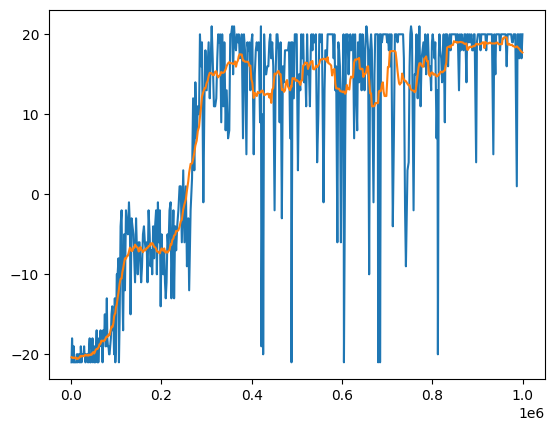

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from baselines.common import plot_util as pu
results = pu.load_results('/content/python/log/openai-2024-03-04-07-02-07-154853')
r = results[0] ## rewards
plt.plot(np.cumsum(r.monitor.l), r.monitor.r)
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=10), )
plt.show();
# pu.plot_results(results)
# pu.plot_results(results, average_group=True)
# pu.plot_results(results, average_group=True, split_fn=lambda _: '')
# plt.show()

# **Continuous Control** (with Unity MLAgents executable)    

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
# !pip -q install ./python
## you can skip this step in colab

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
%cd /content/python
from unityagents import UnityEnvironment
import numpy as np
## select this option to load  the environment
env = UnityEnvironment(file_name='/content/Reacher_Linux_1/Reacher.x86_64', no_graphics=True)
# env = UnityEnvironment(file_name='/content/Reacher_Linux_20/Reacher.x86_64', no_graphics=True)
## set "no_graphics=True" in colab, for there is not monitor to output graphics

/content/python


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [ ]:
print(env_info.vector_observations.dtype)
env_info.__dict__

float64


{'visual_observations': [],
 'vector_observations': array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
          1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
          0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  5.75471878e+00,
         -1.00000000e+00,  5.55726671e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00, -1.68164849e-01]]),
 'text_observations': [''],
 'memories': array([], shape=(0, 0), dtype=float64),
 'rewards': [0.0],
 'local_done': [False],
 'max_reached': [False],
 'agents': [922],
 'previous_vector_actions': array([[0., 0., 0., 0.]]),
 'previous_text_actions': ['']}

In [ ]:
brain.__dict__

{'brain_name': 'ReacherBrain',
 'vector_observation_space_size': 33,
 'num_stacked_vector_observations': 1,
 'number_visual_observations': 0,
 'camera_resolutions': [],
 'vector_action_space_size': 4,
 'vector_action_descriptions': ['', '', '', ''],
 'vector_action_space_type': 'continuous',
 'vector_observation_space_type': 'continuous'}

In [ ]:
## https://www.gymlibrary.dev/environments/mujoco/reacher/
## https://www.gymlibrary.dev/api/spaces/
## gym.make("Reacher-v4")
## Action Space Box(-1.0, 1.0, (2,), float32)
from gym.spaces.box import Box
observation_space = Box(float('-inf'), float('inf'), (brain.vector_observation_space_size,), np.float64)
print(observation_space)
action_space = Box(-1.0, 1.0, (brain.vector_action_space_size,), np.float32)
print(action_space)

Box(-inf, inf, (33,), float64)
Box(-1.0, 1.0, (4,), float32)


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
## e.g. Total score (averaged over agents) this episode: 0.10799999758601189

When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine!

* check [the project instructions](https://www.evernote.com/shard/s139/u/0/sh/7c6da0b2-7cec-45a0-a27a-3e47843353f1/WOhXk8R0l4PFhFESDQ4h-QGUfP0CFMk-okZK-1RqlsuyhFsgkV-Xg6SJeg)  
  * Attempt 1 - amended DDPG, 20 agents  
  * Attempt 2 - amended DDPG, 1 agnet  
  * Attempt 3 - apply **gradient clipping**
```
self.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
self.critic_optimizer.step()
```   
  * Attempt 4 - change update frequency  
  > In particular, instead of updating the actor and critic networks 20 times at every timestep, we amended the code to update the networks 10 times after every 20 timesteps. The corresponding scores are plotted below.  

  And, this was enough to solve the environment! In hindsight, we probably should have realized this fix much earlier, but this long path to the solution was definitely a nice way to help with building intuition! :)  

In [ ]:
from deeprl import *
from unityagents import UnityEnvironment

def ddpg_continuous(env_fn=None, is_mlagents=True, **kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game, env_fn=env_fn, is_mlagents=is_mlagents)
    config.eval_env = config.task_fn()
    config.max_steps = 1000 #int(1e6)
    config.eval_interval = int(1e4)
    config.eval_episodes = 20

    config.network_fn = lambda: DeterministicActorCriticNet(
        config.state_dim, config.action_dim,
        actor_body=FCBody(config.state_dim, (400, 300), gate=F.relu),
        critic_body=FCBody(config.state_dim + config.action_dim, (400, 300), gate=F.relu),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

    config.replay_fn = lambda: UniformReplay(memory_size=int(1e6), batch_size=100)
    config.discount = 0.99
    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim,), std=LinearSchedule(0.2))
    config.warm_up = int(1e4)
    config.target_network_mix = 5e-3
    run_steps(DDPGAgent(config))

def env_fn():
    return UnityEnvironment(file_name="/content/Reacher_Linux_1/Reacher.x86_64", no_graphics=True)
ddpg_continuous(game='Reacher-v2', run=0,
                env_fn=env_fn,
                remark=ddpg_continuous.__name__)

# **Issues**  

🟢⚠️ Warning: if you got `AttributeError: module 'numpy' has no attribute 'bool'.` downgrade the numpy version (`1.23.5` seems to work), or go to `shmem_vec_env.py`, change `np.bool` to `bool`.   

```
/content/python/baselines/baselines/common/vec_env/shmem_vec_env.py in <module>
     15              np.int8: ctypes.c_int8,
     16              np.uint8: ctypes.c_char,
---> 17              np.bool: ctypes.c_bool}
```

# **\<BOTTOM>**  